# Getting Started with Pennylane

Pennylane is a cross-platform python library that connects Quantum computer programming with machine learning methods. It's main goal is to execute circuits and compute gradients which will be used for machine learning and optimization.

The library contains many functions for simulation and running on hardware, with a wide compatibility for platforms.

In [2]:
import pennylane as qml
qml.version()

'0.41.1'

## Quantum circuits

In pennylane, computations are represented by QNodes. These QNodes are combinations of quantum circuits/functions and their environment (e.g. the hardware or simulator that is running the circuit or function). QNodes can interface with the following systems (more information [here](https://docs.pennylane.ai/en/stable/introduction/interfaces.html)):
- Numpy (default)
- PyTorch
- TensorFlow
- JAX

Quantum circuits are represented by python functions.

For this tutorial we will build a simple bell state generating circuit ([pennylane - what are Bell states](https://pennylane.ai/qml/glossary/what-are-bell-states)), which initially will only be able to make the $|\beta_{00}\rangle$ state. But eventually can make any of the four Bell states, based on the input value.

In [4]:
def bell():
    qml.H(wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.Z(wires=0) @ qml.Z(wires=1))

These functions are a restricted subset of python functions with the following properties:
- Accepts classical inputs and consists of quantum operators or sequences of operators
- The function can contains for-loops and if-statements
- The function must always return measurement values. For example an expectation value.

### Defining a device

To actually run the circuit we must define a device. In this case we will create a simulation device. Basic devices are already provided in the library:
- `default.qubit`
- `default.mixed`
- `lightning.qubit`

With more information to be found [here](https://pennylane.ai/devices/). Device choice can significantly influence performance.

When creating a device, the name of the choice must always be specified. Then it needs an amount of wires (in this case qubits) end how many shots the circuit should be run for. Wires can be specified as integer, or as a list of identifiers. Then, in the quantum function these labels can also be used.

For the shots parameter, it is also possible to perform shots batching by passing a list of shots to the device initialisation.

In [ ]:
dev = qml.device('default.qubit', wires=['q1', 'q2'], shots=1000)

@qml.qnode(dev)
def bell():
    """
    Create a bell state of a provided input state
    |00> => |Φ+>
    """
    qml.H(wires='q1')
    qml.CNOT(wires=['q1', 'q2'])
    # Measure the Z expectation value of each individual qubit and the combined system
    # Since we have the 00 Bell state, the (ideal) result should be (0, 0, 1)
    # Completely uncorrelated subsystems, perfectly correlated combined system.
    return qml.expval(qml.Z(wires='q1')), qml.expval(qml.Z(wires='q2')), qml.expval(qml.Z(wires='q1') @ qml.Z(wires='q2'))

### Quantum Nodes

Then we can combine the device and the circuit function into a QNode. For this we can explicitly create the QNode with `qml.QNode(quantum_function, device)`. But we can also use the `@qml.qnode(device)` decorator (as you can see above). When this is done, we can start by drawing the circuit to verify if it is correct.

(<Figure size 500x300 with 1 Axes>, <Axes: >)

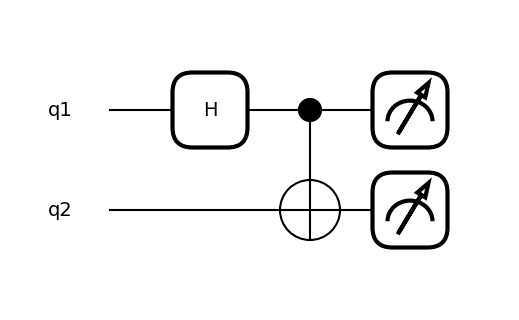

In [102]:
# The `qml.draw_mpl` function takes in a circuit and returns a function that will draw the circuit.
qml.draw_mpl(bell)()

In [ ]:
# Run the circuit and get three expectation values. One for each subsystem and one for the combined system. 
# Since we are measuring the combination of the expectation value of the Z-operator on both qubits, we expect the result to be 1. 
# This is because the expectation value of a single subsystem is either 1 for |0> or -1 for |1> for the Z-measurement.
# Since we have a Bell state |β_00> (also goes for |β_10>), the qubits should always come out the same. 
# So multiplying the expectation values of the subsystem always gives 1.
# For the other Bell states, where the qubits will always turn out opposite, the expectation value of the combined system will be -1.
bell()

(np.float64(-0.024), np.float64(-0.024), np.float64(1.0))

### Parametrizing circuits

Our `bell()` function is currently only capable of building the `|00> -> |Φ+>` bell state. We can combine function parameters with `qml.StatePrep` to configure the circuit. To make an arbitrary bell state, we can just prepare a different input state and that will give the corresponding entangled output. For more info read 

In [ ]:
@qml.qnode(dev)
def bell(input: str = "00"):
    """
    Create a bell state of a provided input state
    |00> => |Φ+>
    |01> => |Ψ+>
    |10> => |Φ->
    |11> => |Ψ->
    """
    match input:
        case "00":
            state = [1, 0, 0, 0]
        case "01":
            state = [0, 1, 0, 0]
        case "10":
            state = [0, 0, 1, 0]
        case "11":
            state = [0, 0, 0, 1]
        case _:
            raise ValueError("Input must be one of ['00', '01', '10', '11']")
        
    qml.StatePrep(state, wires=['q1', 'q2'])
    qml.H(wires='q1')
    qml.CNOT(wires=['q1', 'q2'])
    
    return qml.sample(None, wires=['q1', 'q2'])

(<Figure size 600x300 with 1 Axes>, <Axes: >)

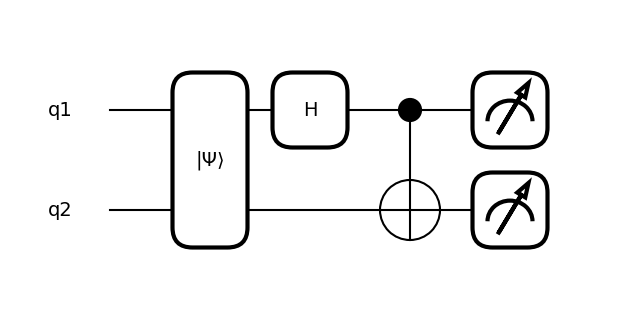

In [50]:
qml.draw_mpl(bell)('11')

In [57]:
import numpy as np

# Running the circuit with '00' or '10' as input should always return the same result for the measurement of the qubits (in the ideal case).
# This is the fundamental property of the Bell states. Try it out by changing the input to the circuit below.
result = bell("00")
all_the_same = np.all([x[0] == x[1] for x in result])
all_different = np.all([x[0] != x[1] for x in result])

f"The bits are {'all the same' if all_the_same else 'all different' if all_different else 'mixed'}"

'The bits are all the same'

### Sharing circuits between other libraries and pennylane

Pennylane allows other libraries to share circuits with it. This can be done through QASM, which is supported by most Quantum information libraries, or with specialised interfaces for specific libraries like qiskit or quil.

In the following example we'll make a quantum circuit in QuTiP, then export it as QASM to then import it into qiskit. Then we can import both the original QASM circuit and the recreated qiskit circuit into pennylane.

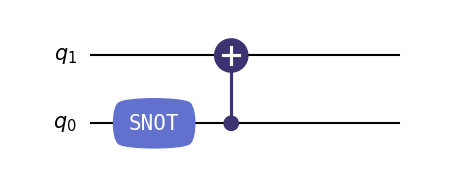

In [112]:
from qutip import tensor, basis
from qutip_qip.operations import hadamard_transform, cnot
from qutip_qip.circuit import QubitCircuit
from qutip_qip.qasm import circuit_to_qasm_str
from qiskit.qasm2 import loads

circ = QubitCircuit(2)
circ.add_gate("SNOT", 0)
circ.add_gate("CNOT", 1, 0)
circ.draw()

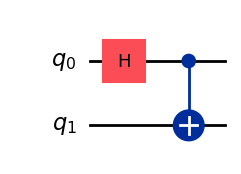

In [115]:
qasm = circuit_to_qasm_str(circ)
qiskit_circ = loads(qasm)
qiskit_circ.draw('mpl')

In [ ]:
# Version incompatibilities unfortunately. So this does not work in recent versions
# See: https://github.com/PennyLaneAI/pennylane-qiskit/releases/tag/v0.39.1
# When the dependencies are updated I'll update this section too. For now, if you need this functionality,
# the only option seems to be to return to an older version of qiskit.

# Both these function calls return a function representing the quantum circuit, as customary in pennylane
# qml.from_qiskit(qiskit_circ)
# qml.from_qasm(qasm)